# WaveRNN - Fit a Sine Wave

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import time, sys, math
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
from utils.display import *
from models.wavernn import WaveRNN

In [43]:
notebook_name = 'nb1'
sample_rate = 24000

In [44]:
def sine_wave(freq, length, sample_rate=sample_rate) : 
    return np.sin(np.arange(length) * 2 * math.pi * freq / sample_rate).astype(np.float32)

In [45]:
signal = sine_wave(1, 100000)

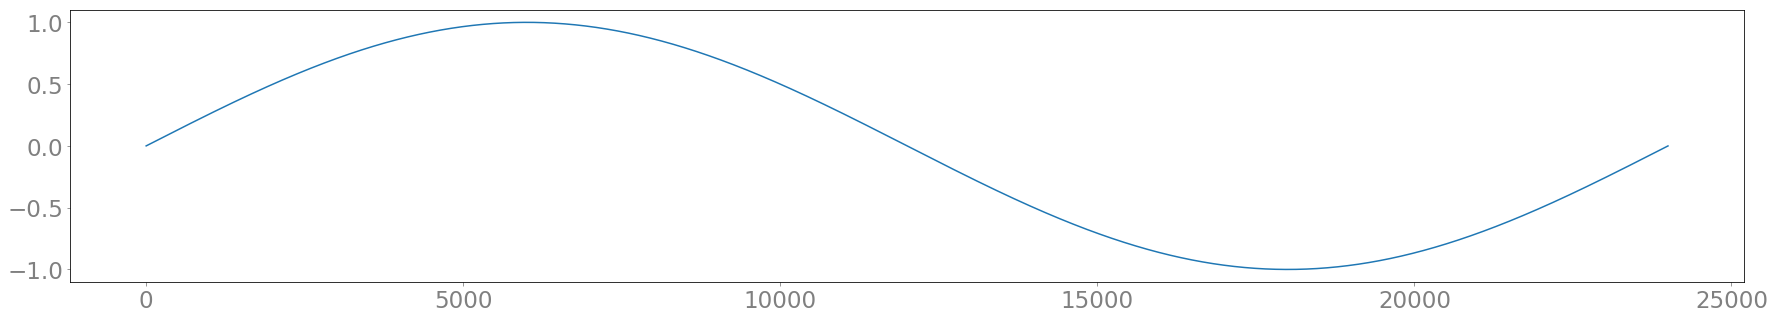

In [46]:
plot(signal[:sample_rate])

### Splitting the Signal

In [47]:
def encode_16bits(x) : 
    return np.clip(x * 2**15, -2**15, 2**15 - 1).astype(np.int16)

In [48]:
def split_signal(x) :
    encoded = encode_16bits(x)
    unsigned = encoded + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [49]:
c, f = split_signal(signal)

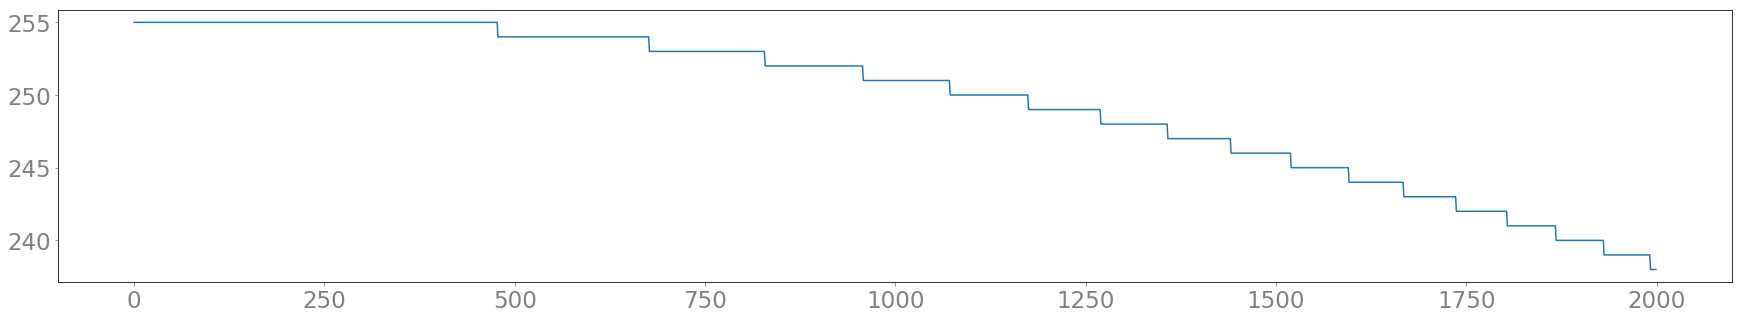

In [50]:
plot(c[30000:32000])

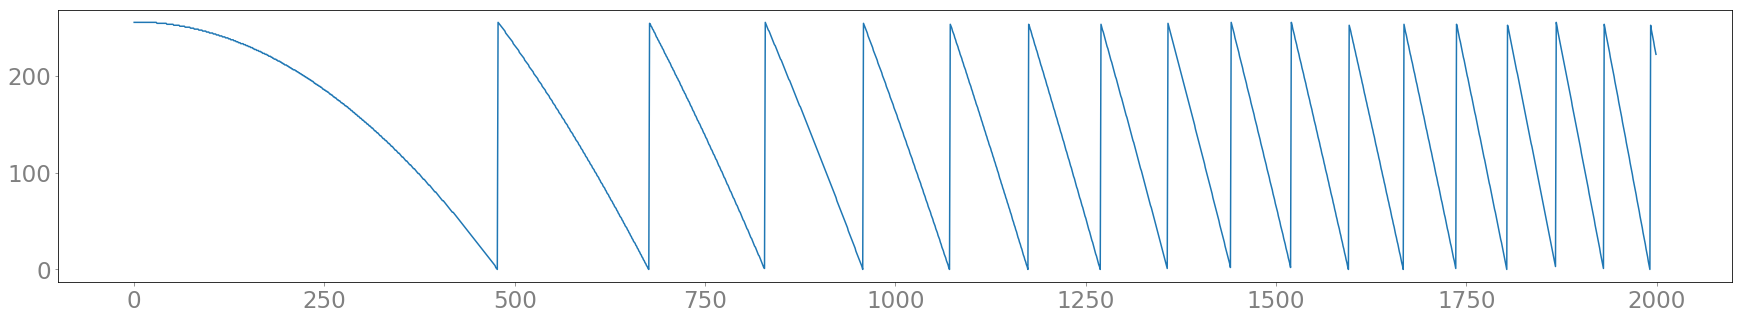

In [51]:
plot(f[30000:32000])

In [52]:
c.max(), c.min(), f.max(), f.min()

(255, 0, 255, 0)

### Reconstructing the Signal

In [53]:
def combine_signal(coarse, fine) :
    signal = coarse * 256 + fine 
    signal -= 2**15
    return signal.astype(np.int16) 

In [54]:
reconstructed = combine_signal(c, f)

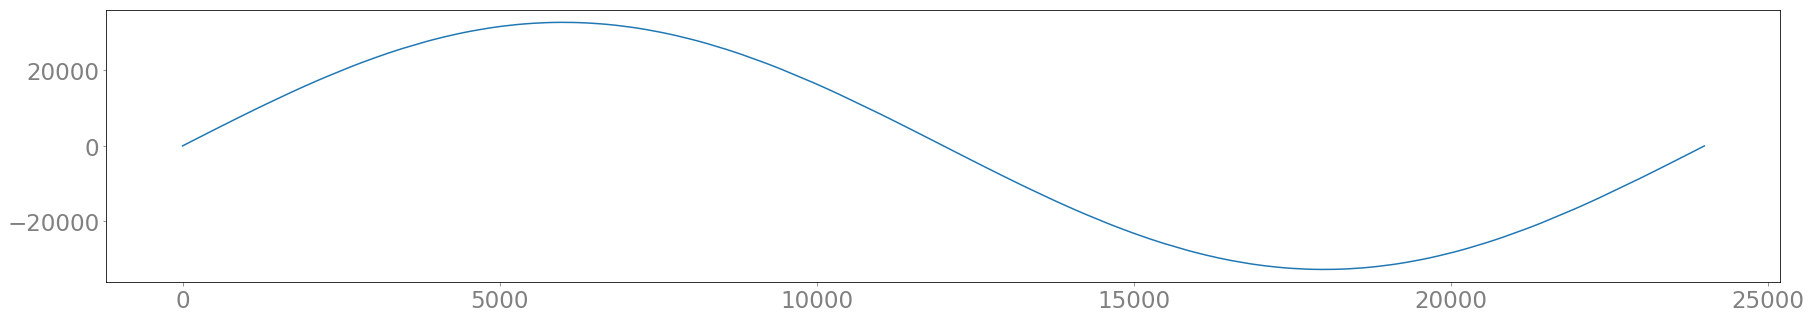

In [55]:
plot(reconstructed[:sample_rate])

In [56]:
before_signal = sine_wave(freq=500, length=sample_rate * 5)
c, f = split_signal(before_signal)
before_signal = encode_16bits(before_signal)
reconstructed = combine_signal(c, f)

In [57]:
wavfile.write('model_outputs/nb1/combine_test_before.wav', sample_rate, before_signal)
wavfile.write('model_outputs/nb1/combine_test_after.wav', sample_rate, reconstructed)

In [58]:
model = WaveRNN().cuda()

Trainable Parameters: 3.050 million


### Check Tensor Shapes

In [63]:
hidden = model.init_hidden()

In [64]:
x = torch.rand(1, 2).cuda()
current_course = torch.rand(1, 1).cuda()

In [65]:
c, f, hidden = model(x, hidden, current_course)

In [66]:
c.size(), f.size(), hidden.size()

(torch.Size([1, 256]), torch.Size([1, 256]), torch.Size([1, 896]))

### Train Model

In [67]:
x = sine_wave(freq=500, length=sample_rate * 30)
coarse_classes, fine_classes = split_signal(x)
coarse_classes = np.reshape(coarse_classes, (1, -1))
fine_classes = np.reshape(fine_classes, (1, -1))

In [68]:
def train(model, optimizer, num_steps, seq_len=960) :
    
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :
        
        loss = 0
        hidden = model.init_hidden()
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        for i in range(seq_len) :
            
            j = rand_idx + i
            
            x_coarse = coarse_classes[:, j:j + 1]
            x_fine = fine_classes[:, j:j + 1]
            x_input = np.concatenate([x_coarse, x_fine], axis=1)
            x_input = x_input / 127.5 - 1.
            x_input = torch.FloatTensor(x_input).cuda()
            
            y_coarse = coarse_classes[:, j + 1]
            y_fine = fine_classes[:, j + 1]
            y_coarse = torch.LongTensor(y_coarse).cuda()
            y_fine = torch.LongTensor(y_fine).cuda()
            
            current_coarse = y_coarse.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, y_coarse)
            loss_fine = F.cross_entropy(out_fine, y_fine)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.item() / seq_len)
        loss.backward()
        optimizer.step()
        
        speed = (step + 1) / (time.time() - start)
        
        stream('Step: %i/%i --- Loss: %.1f --- Speed: %.1f batches/second ', 
              (step + 1, num_steps, running_loss / (step + 1), speed))    

In [69]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [70]:
train(model, optimizer, num_steps=300)

Step: 300/300 --- Loss: 0.6 --- Speed: 0.9 batches/second 

### Generate

In [71]:
output, c, f = model.generate(10000)

Gen: 10000/10000 -- Speed: 1163

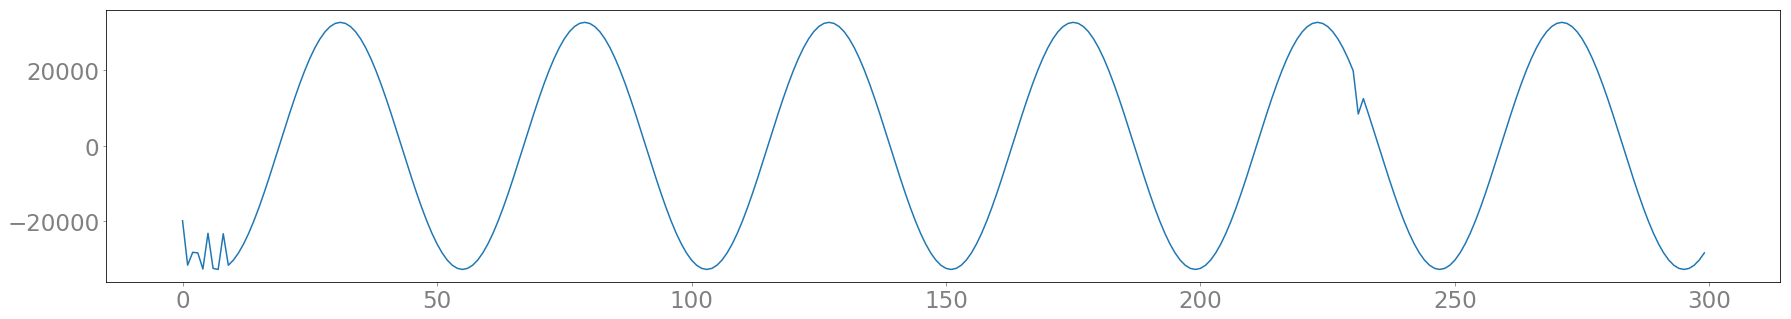

In [72]:
plot(output[:300])

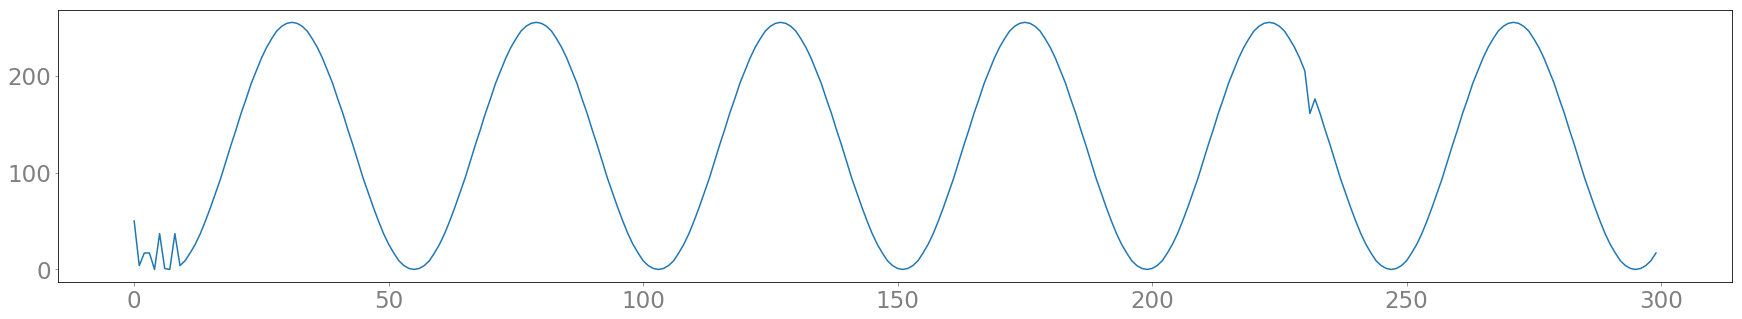

In [73]:
plot(c[:300])

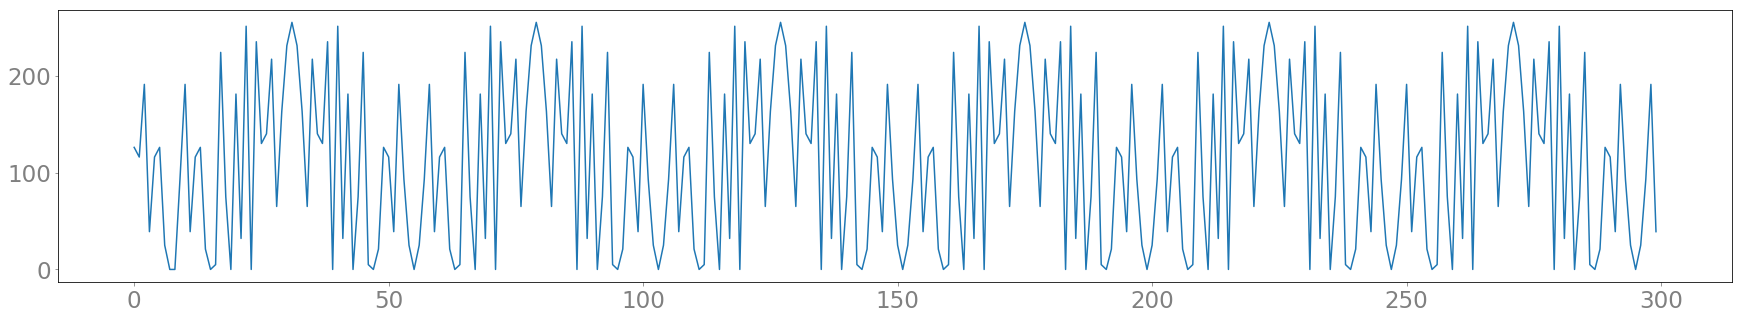

In [74]:
plot(f[:300])

And compare the fine output to the ground truth...

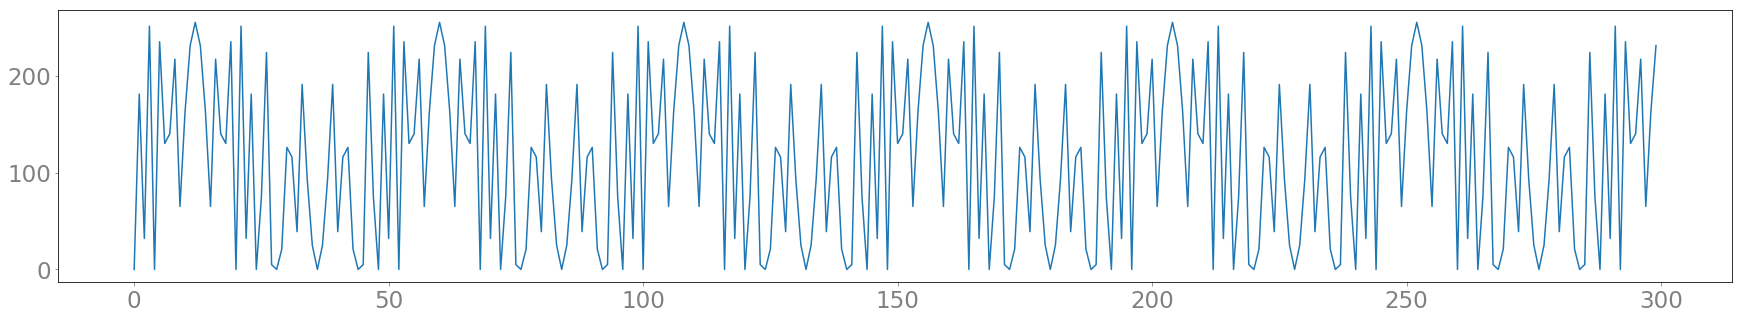

In [75]:
plot(fine_classes[0, :300])

In [76]:
wavfile.write('outputs/nb1/model_output.wav', sample_rate, output)